In [87]:
import numpy as np
import pybacktrack as pbt
import paleogeography as pg
import sys
from pigplates import sphere_tools as pigsph

sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')

from raster_reconstruction_classes import *
from reconstruction_classes import *
from reconstruct_atom_rasters import *

rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'
static_polygon_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_ContinentalPolygons_2012.1.gpmlz'

S2012 = ReconstructionModel('Seton++2012')
S2012.add_rotation_model(rotation_filename)
S2012.add_static_polygons(static_polygon_filename)

rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/MULLER2016/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
static_polygon_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/MULLER2016/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz'

Mu2016 = ReconstructionModel('Muller++2016')
Mu2016.add_rotation_model(rotation_filename)
Mu2016.add_static_polygons(static_polygon_filename)

agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'



/Users/Simon/GIT/paleogeography/paleogeography.py:357: RuntimeWarning: invalid value encountered in greater_equal
  paleodepth[age_array>=20.] = 5651 - 2473*np.exp(-0.0278*age_array[age_array>=20.])
/Users/Simon/GIT/paleogeography/paleogeography.py:356: RuntimeWarning: invalid value encountered in sqrt
  paleodepth = 2600. + 365. * np.sqrt(age_array)


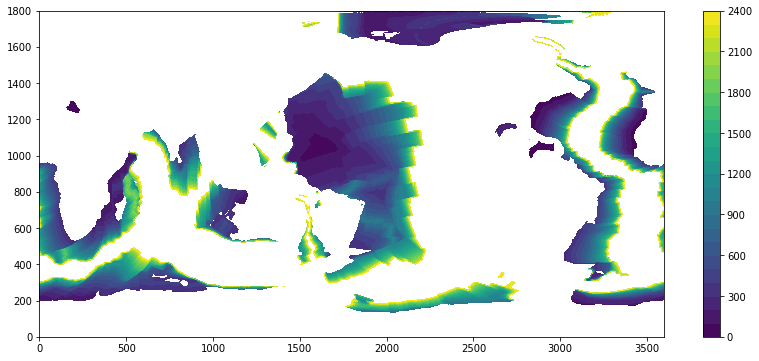

In [4]:
topography = GplatesRaster('../data/ETOPO1_0.1.grd')

agegrid = GplatesRaster('../data/agegrid_6m.grd')

#point_depths = []
#for point_age in agegrid.gridZ.flatten():
#    point_depths.append(pbt.convert_age_to_depth(point_age))
 
present_depth = pg.age2depth(agegrid.gridZ)
past_depth = pg.age2depth(agegrid.gridZ-60.)

subsidence = past_depth-present_depth


plt.figure(figsize=(14,6))
plt.contourf(subsidence,levels=np.arange(0,2500,100))
plt.colorbar()
#print point_depths


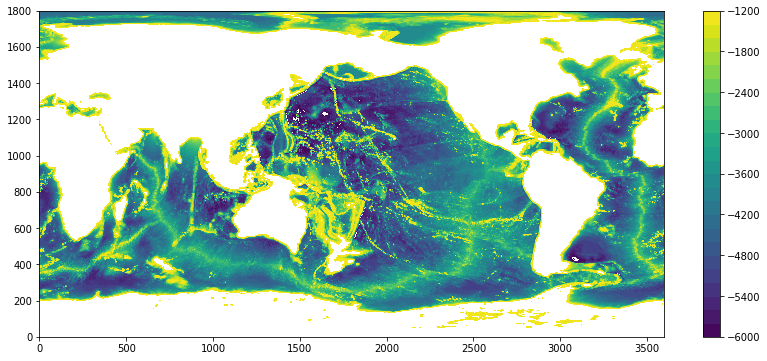

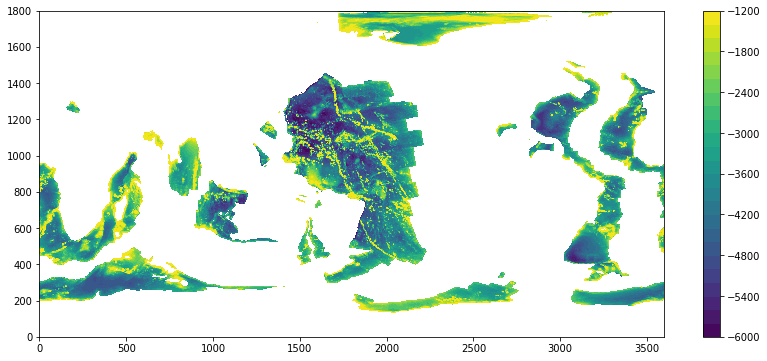

In [48]:
plt.figure(figsize=(14,6))
plt.contourf(topography.gridZ,levels=np.arange(-6000,-1000,200))
plt.colorbar()

backtrack_depth = topography.gridZ+subsidence

plt.figure(figsize=(14,6))
plt.contourf(backtrack_depth,levels=np.arange(-6000,-1000,200))
plt.colorbar()



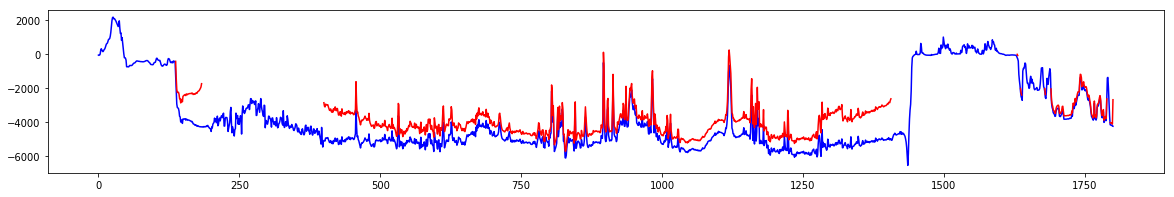

In [51]:
plt.figure(figsize=(20,3))
plt.plot(topography.gridZ[:,2000],'b')
plt.plot(backtrack_depth[:,2000],'r')


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


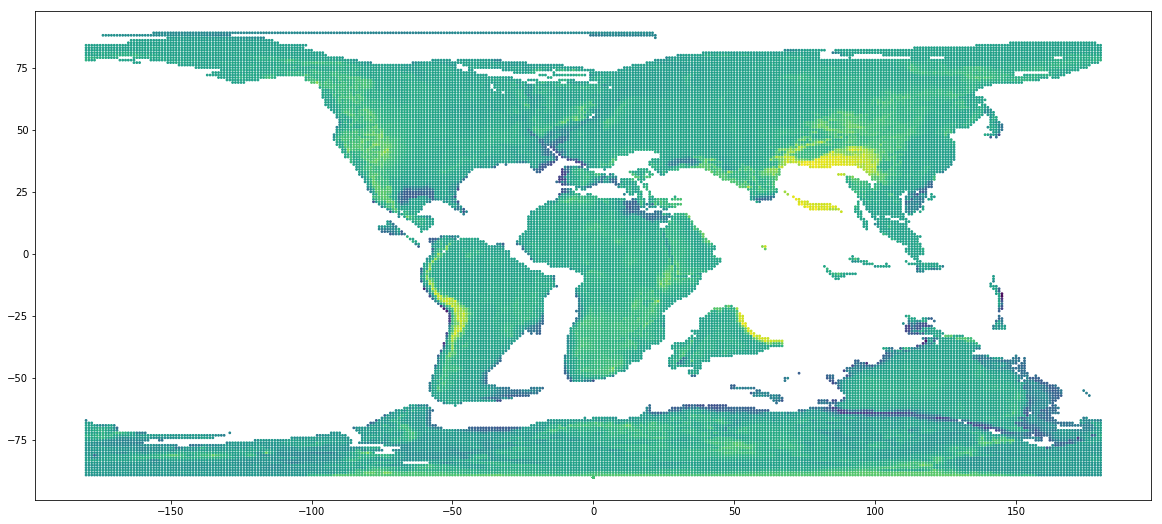

In [64]:
from_time = 0.
to_time = 95.

(reconstructed_point_lons,
 reconstructed_point_lats,
 reconstructed_topography_points) = reconstruct_raster(topography, Mu2016.static_polygons, Mu2016.rotation_model,
                                                       from_time, to_time, grid_sampling=1.0)

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
            c=reconstructed_topography_points,s=3)
plt.show()


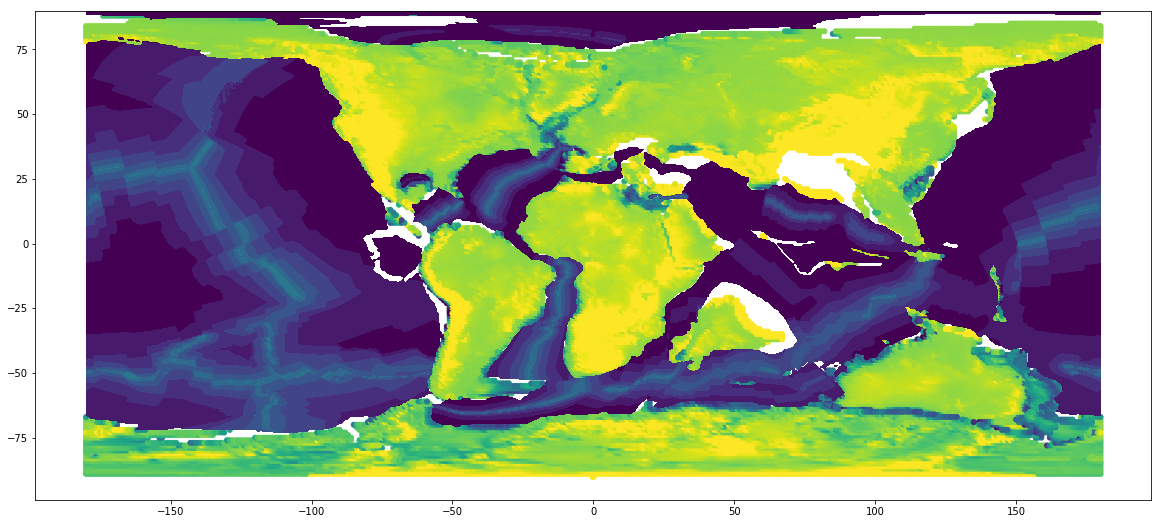

In [125]:
paleoage = GplatesRaster(agegrid_file_template % to_time)

seafloor_depth = pg.age2depth(paleoage.gridZ)

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
            c=reconstructed_topography_points,s=25,vmin=-5000,vmax=1000)
plt.contourf(paleoage.gridX,paleoage.gridY,seafloor_depth,vmin=-5000,vmax=1000)
#plt.axis([0,150,-80,20])
plt.show()


gpml:OrogenicBelt
gpml:OrogenicBelt
gpml:OrogenicBelt


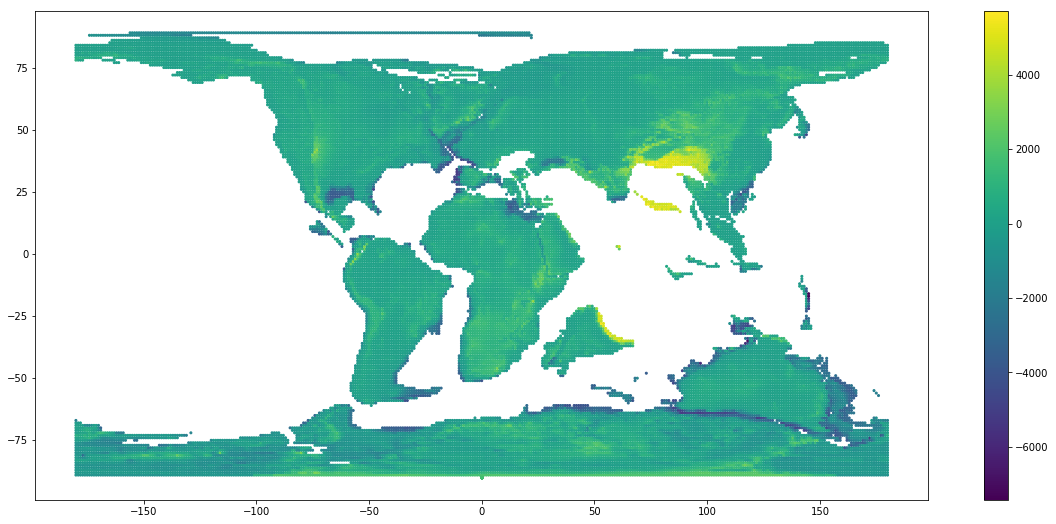

In [69]:
scaled_reconstructed_topography_points = np.copy(reconstructed_topography_points)

points = [pygplates.LatLonPoint(lat,lon) for lat,lon in zip(reconstructed_point_lats,reconstructed_point_lons)]

orogeny_file = '../data/OrogenMasks.gpml'
orogeny_polygon_features = pygplates.FeatureCollection(orogeny_file)
#pygplates.reconstruct(orogeny_file, Mu2016.rotation_model)

for orogeny_polygon_feature in orogeny_polygon_features:
    res = run_grid_pip(to_time, points, orogeny_polygon_feature, Mu2016.rotation_model, anchor_plate_id=0)
    
    print orogeny_polygon_feature.get_feature_type()
    scaled_reconstructed_topography_points[np.where(res)] = reconstructed_topography_points[np.where(res)]*0.5

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
            c=scaled_reconstructed_topography_points,s=4)
plt.colorbar()
plt.show()



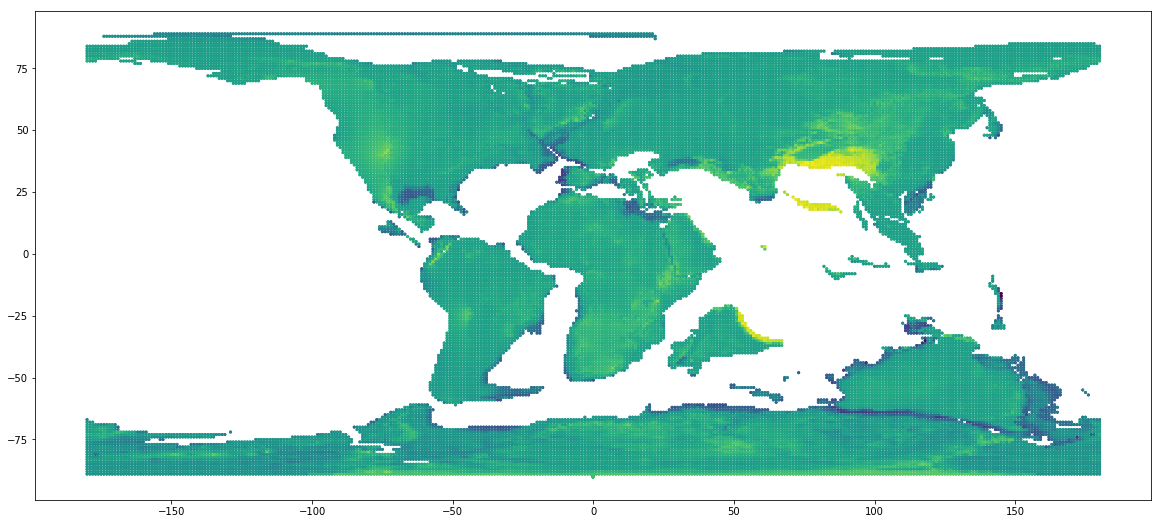

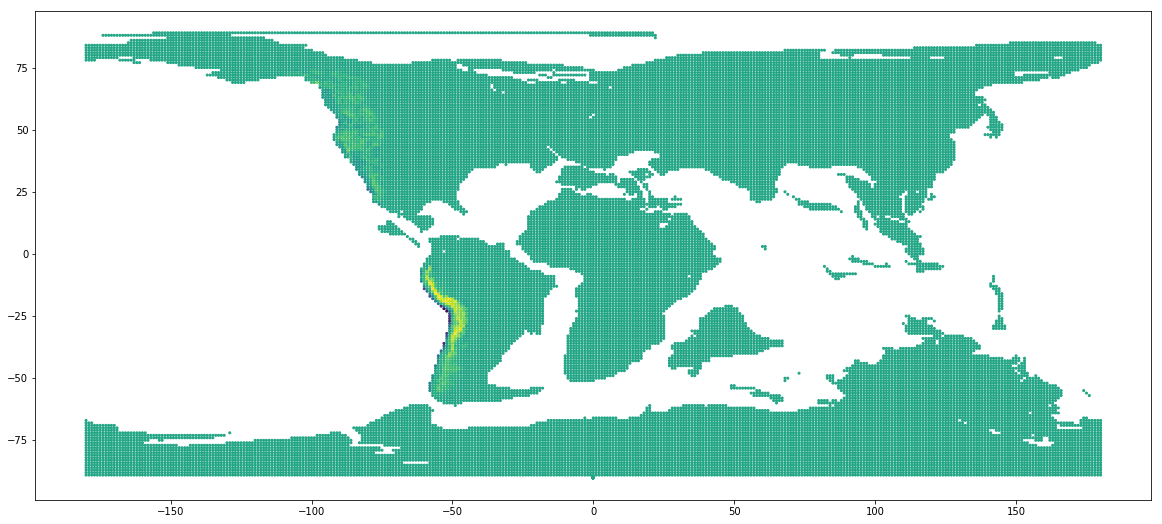

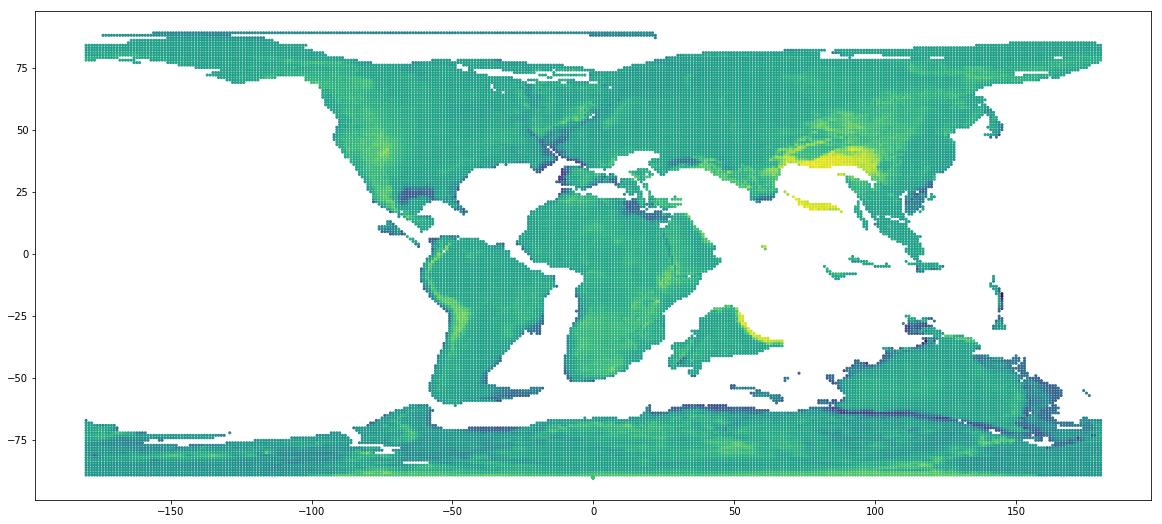

In [124]:
# Note to self
# The idea of this cell is
# Within polygons that define 'high topography', find a planar surface that interpolates linearly across (within) the polygon
# based on the topography at the polygon edges
# Make a new global set of topography points where the values within the polygons are based on this
# interpolated surface - a bit like 'chopping off' the mountains and replacing them with a roughly planar surface (but n
# not neccesarily flat) - this is the 'planed_reconstructed_topography_points'
# The residual between planed topography and the true topography is the excess in the mountain ranges. 
# We can then scale this excess topography by any arbitray factor, then add it back to the planed topography


tessellation_sampling_degrees = 2.

planed_reconstructed_topography_points = np.copy(reconstructed_topography_points)


plt.figure(figsize=(20,9))
#plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
#            c=scaled_reconstructed_topography_points,s=4)
#plt.colorbar()
#plt.show()

for orogeny_polygon_feature in orogeny_polygon_features:
    
    # NOTE:
    # The sampling of the present-day topography could be done at present-day, not reconstrucuted??
    reconstructed_polygon = []
    pygplates.reconstruct(orogeny_polygon_feature, Mu2016.rotation_model, reconstructed_polygon, to_time)
    
    if len(reconstructed_polygon)>0:
        tessellated_points = reconstructed_polygon[0].get_reconstructed_geometry().to_tessellated(np.radians(tessellation_sampling_degrees))
        
        #print tessellated_points.to_lat_lon_array()
        d,l = pigsph.sampleOnSphere(np.array(reconstructed_point_lons),
                                    np.array(reconstructed_point_lats),
                                    reconstructed_topography_points,
                                    tessellated_points.to_lat_lon_array()[:,1],
                                    tessellated_points.to_lat_lon_array()[:,0],
                                    k=64)
    
        w = np.divide(1.,d**2, out=np.ones_like(d), where=d!=0)
        polygon_edge_topography = np.sum(w * reconstructed_topography_points.ravel()[l],axis=1) / np.sum(w,axis=1)
    
        # find grid points inside the polygon
        res = run_grid_pip(to_time, points, orogeny_polygon_feature, Mu2016.rotation_model, anchor_plate_id=0)

        d,l = pigsph.sampleOnSphere(tessellated_points.to_lat_lon_array()[:,1],
                                    tessellated_points.to_lat_lon_array()[:,0],
                                    polygon_edge_topography,
                                    np.array(reconstructed_point_lons)[np.where(res)],
                                    np.array(reconstructed_point_lats)[np.where(res)],
                                    k=64)
    
        w = np.divide(1.,d**2, out=np.ones_like(d), where=d!=0)
        point_z = np.sum(w * polygon_edge_topography.ravel()[l],axis=1) / np.sum(w,axis=1)

        planed_reconstructed_topography_points[np.where(res)] = point_z
        
        #plt.scatter(tessellated_points.to_lat_lon_array()[:,1],
        #            tessellated_points.to_lat_lon_array()[:,0],
        #            c=polygon_edge_topography)
        
        #plt.scatter(np.array(reconstructed_point_lons)[np.where(res)],
        #            np.array(reconstructed_point_lats)[np.where(res)],
        #            c=point_z)
        
        plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
                    c=planed_reconstructed_topography_points,s=4)
        
        #plt.plot(np.array(reconstructed_point_lons)[np.where(res)],
        #         np.array(reconstructed_point_lats)[np.where(res)],'.')
        

excess_topography = reconstructed_topography_points - planed_reconstructed_topography_points

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
            c=excess_topography,s=4)
plt.show()

plt.figure(figsize=(20,9))
plt.scatter(reconstructed_point_lons,reconstructed_point_lats,
            c=planed_reconstructed_topography_points + (excess_topography*0.5),s=4)
plt.show()

